# Multi stand level modelling in libcbm

In [1]:
from libcbm.model.cbm import cbm_variables
from libcbm.model.cbm import cbm_simulator
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.model.cbm.stand_cbm_factory import StandCBMFactory
from libcbm.storage import dataframe
import pandas as pd
import numpy as np

define the CBM classifiers

In [2]:
classifiers = {
    "c1": ["c1_v1"],
    "c2": ["c2_v1"],
}

define one or more merchantable volumes.  The relationship between stands and volumes is defined by the classifier sets.

In [3]:
merch_volumes = [
    {
        "classifier_set": ["c1_v1", "?"],
        "merch_volumes": [
            {
                "species": "Spruce",
                "age_volume_pairs": [
                    [0, 0],
                    [50, 100],
                    [100, 150],
                    [150, 200],
                ],
            }
        ],
    }
]

define the inventory to simulate

In [4]:
n_steps = 50
n_stands = 1000
inventory = dataframe.from_pandas(
    pd.DataFrame(
        index=list(range(0, n_stands)),
        columns=[
            "c1",
            "c2",
            "admin_boundary",
            "eco_boundary",
            "age",
            "area",
            "delay",
            "land_class",
            "afforestation_pre_type",
            "historic_disturbance_type",
            "last_pass_disturbance_type",
        ],
        data=[
            [
                "c1_v1",
                "c2_v1",
                "Ontario",
                "Mixedwood Plains",
                15,
                1.0,
                0,
                "UNFCCC_FL_R_FL",
                "None",
                "Wildfire",
                "Wildfire",
            ]
        ],
    )
)

simulate using `StandCBMFactory`

note pre-dynamics func argument may be used to inspect and or modify the CBM state, variables and parameters in the simulation loop.  In this example it is used to assign a disturbance type to all stands on timestep = 10

In [5]:
def pre_dynamics(t, cbm_vars):
    if t == 10:
        parameters = cbm_vars.parameters.to_pandas()
        # note type changes will not be allowed in libcbm, so care must be used when using pandas
        parameters.loc[:, "disturbance_type"] = np.int32(1)
        cbm_vars.parameters = dataframe.from_pandas(parameters)
    else:
        parameters = cbm_vars.parameters.to_pandas()
        parameters.loc[:, "disturbance_type"] = np.int32(0)
        cbm_vars.parameters = dataframe.from_pandas(parameters)
    return cbm_vars


n_stands = inventory.n_rows

cbm_factory = StandCBMFactory(classifiers, merch_volumes)
csets, inv = cbm_factory.prepare_inventory(inventory)

with cbm_factory.initialize_cbm() as cbm:
    cbm_output = CBMOutput(
        classifier_map=cbm_factory.classifier_value_names,
        disturbance_type_map=cbm_factory.disturbance_types,
    )
    cbm_simulator.simulate(
        cbm,
        n_steps=n_steps,
        classifiers=csets,
        inventory=inv,
        pre_dynamics_func=pre_dynamics,
        reporting_func=cbm_output.append_simulation_result,
    )

plot the mean age to confirm the disturbance event had an effect on age

<AxesSubplot:xlabel='timestep'>

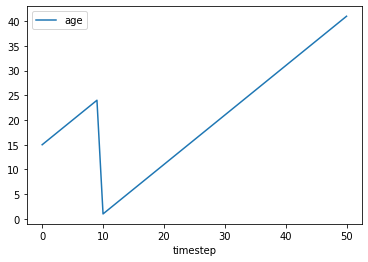

In [6]:
cbm_output.state.to_pandas()[["timestep", "age"]].groupby(
    "timestep"
).mean().plot()